In [1]:
import numpy as np
np.random.seed(1001)

import os
import shutil
import librosa
from librosa import display

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
# from sklearn.cross_validation import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
train = pd.read_csv("../../../ESC-50-master/meta/esc50.csv")
TARGETS = [0,1,2,3,4,5,6,7,8,9,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]

In [3]:
train.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Text(0, 0.5, 'Number of Samples')

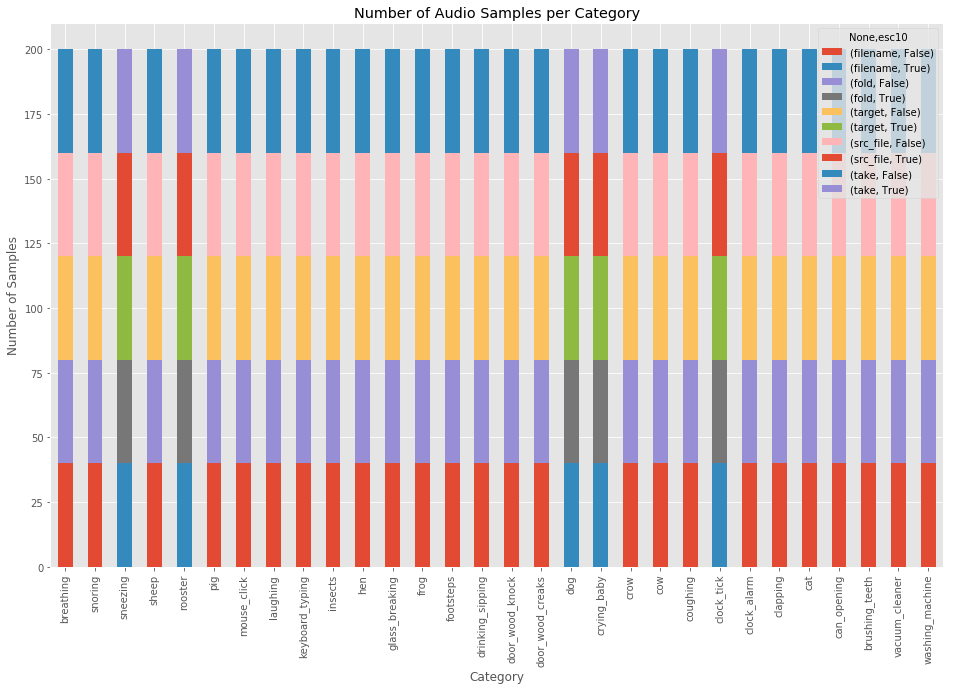

In [4]:
category_group = train[train['target'].isin(TARGETS)].groupby(['category', 'esc10']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples")

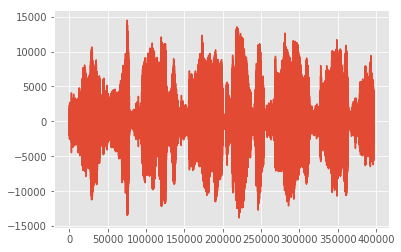

In [5]:
from scipy.io import wavfile
import IPython.display as ipd  # To play sound in the notebook

t_fname = '../audio_samples/signal_9s.wav'

rate, t_signal = wavfile.read(t_fname)

min_len = len(t_signal)

# 16 bits tracks, normalization
t_signal = np.array([(e/2**16.0)*2 for e in t_signal])

t_signal = t_signal[:min_len]
new_sig = t_signal

new_sig_16b = np.array([int((v*2**16.0)/2) for v in new_sig])
plt.plot(new_sig_16b)

ipd.Audio(new_sig_16b, rate=44100)

In [6]:
class Config(object):
    def __init__(self,
                 sampling_rate=22050, 
                 n_classes=41,
                 train_dir='../AudioTagging/audio_train',
                 n_mels=64, 
                 frame_weigth=80, 
                 frame_shift=10):

        self.sampling_rate = sampling_rate
        self.n_classes = n_classes
        self.train_dir = train_dir

        self.n_fft = int(frame_weigth / 1000 * sampling_rate)
        self.n_mels = n_mels
        self.frame_weigth = frame_weigth
        self.frame_shift = frame_shift
        self.hop_length = int(frame_shift / 1000 * sampling_rate)

        
def get_subset(csv_file, n):
    """
    Train set is too big. We get a subset to display.
    """
    train = pd.read_csv(csv_file)
    train = train.sort_values(by=['label', 'fname'])

    LABELS = list(train.label.unique())

    subset = train.iloc[[0]]
    
    # choose n files from each category randomly.
    for label in LABELS:
        subset = subset.append(train[train.label == label].sample(n))

    subset = subset.iloc[1:]
    return subset

def get_folder_subset(dest='../../../baby_cry_detection/data/301 - Crying baby'):
#     dest = '../audio_samples'
#     dest = '../../../baby_cry_detection/data/301 - Crying baby'
    file_list = os.listdir(dest)
    df = pd.DataFrame({ "fname": file_list,
                        "label": 'crying_baby', 
                        "manually_verified": 1})
    return df


def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes(
        [x, y, box.width * position[2], box.height * position[3]],
        # axisbg='w'
    )


def plot_one_file(row, ax):
    fname = os.path.join(config.train_dir, row['fname'])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_logmel = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    data, _ = librosa.load(fname, sr=config.sampling_rate)
    melspec = librosa.feature.melspectrogram(data, 
                                             sr=config.sampling_rate,
                                             n_fft=config.n_fft, 
                                             hop_length=config.hop_length,
                                             n_mels=config.n_mels)

    logmel = librosa.core.power_to_db(melspec)
#     logmel = melspec
    
    ax_waveform.plot(data, '-')
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title('{0} \n {1}'.format(row['label'], row['fname']), {'fontsize': 8}, y=1.03)

    librosa.display.specshow(logmel, sr=config.sampling_rate)
    ax_logmel.get_xaxis().set_visible(False)
    ax_logmel.get_yaxis().set_visible(False)


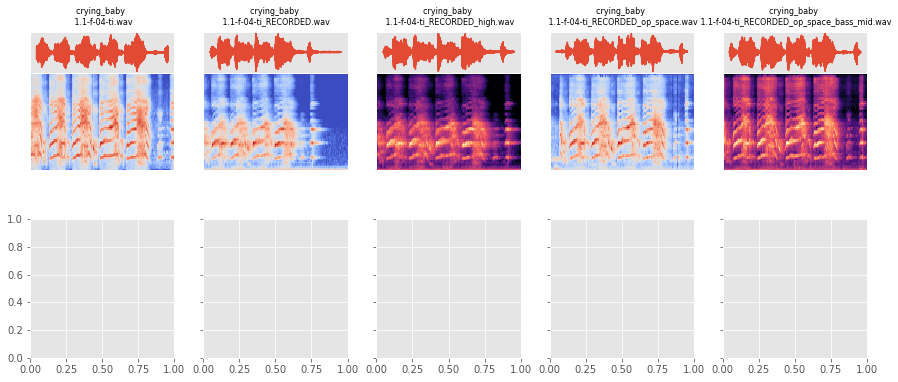

In [10]:
# frame_weight: 80ms, frame_shift:10ms
config = Config(sampling_rate=16000, 
                n_classes=2,
                frame_weigth=80, 
                frame_shift=10, 
                train_dir='../../../AudioTagging/audio_train')

files_shown = 5 
subset = get_subset('../../../AudioTagging/train.csv', files_shown)

f, axes = plt.subplots(config.n_classes,
                       files_shown,
                       figsize=(files_shown * 3, config.n_classes * 3),
                       sharex=True,
                       sharey=True)
f.subplots_adjust(hspace=0.35)

# print(subset)#

# for i, (_, row) in enumerate(subset.iterrows()):
#     plot_one_file(row, axes[i//files_shown, i%files_shown])

# train_dir='../../../baby_cry_detection/data/903 - Baby laugh'
train_dir = '../../output/recorded_sound'
config = Config(sampling_rate=16000, 
                frame_weigth=80, 
                frame_shift=10, 
                # train_dir='../audio_samples'
                train_dir=train_dir
               )
subset = get_folder_subset(dest=train_dir)
for i, (_, row) in enumerate(subset.iterrows()):
    plot_one_file(row, axes[i//files_shown, i%files_shown])
